In [1]:
#量子变分线路二分类器实现，使用MNIST数据集
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (25, 16.0) # 显示大小

In [2]:
#载入数据集
num=10000
def Load_mnist():
    mnist=np.genfromtxt("mnist_train.csv",delimiter=",",max_rows=num)
    labels_mnist=mnist[:,0]
    imgs_mnist=mnist[:,1:]
    return labels_mnist,imgs_mnist
labels,imgs=Load_mnist()

#抽取“0”和“1”
labels_01=[]
imgs_01=[]
for i in range(10000):
    if (labels[i]==0):   #若图像为“0”，则打标签：-1
        labels_01.append(labels[i])
        labels_01[-1]-=1
        imgs_01.append(imgs[i])
    if (labels[i]==1):   #若图像为“1”，则打标签：1
        labels_01.append(labels[i])
        imgs_01.append(imgs[i])


In [3]:
#PCA降维
pca=PCA(n_components=256)
imgs_01_new=pca.fit_transform(imgs_01)                                          #降维后的数据
print(imgs_01_new.shape)
imgs_recovered = pca.inverse_transform(imgs_01_new)
print(imgs_recovered.shape)                                                     #反降维的数据
labels_01=np.array(labels_01)

(2128, 256)
(2128, 784)


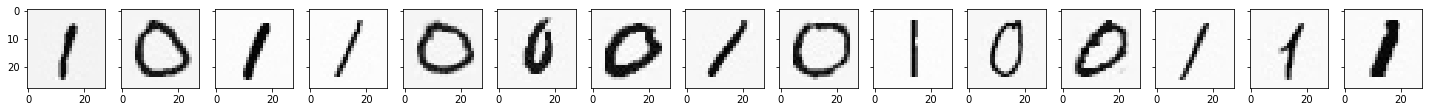

In [4]:
#以图片形式查看一下数据
num=15
fig, ax = plt.subplots(nrows=1,ncols=num,sharex=True,sharey=True)
ax = ax.flatten()
n=np.random.randint(0,2128,size=num)
for i in range(num):
    ax[i].imshow(imgs_recovered[n[i]].reshape(28,28), cmap='Greys', interpolation='nearest')

In [5]:
#定义量子变分线路分类器
num_layers = 10
num_qubits=8
dev = qml.device("default.qubit", wires=num_qubits)
def layer(W):                                                                                #定义layer函数，用于给量子线路铺层
    for i in range(num_qubits):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
    for i in range(num_qubits):
        if(i!=num_qubits-1):
            qml.CNOT(wires=[i,i+1])
            
@qml.qnode(dev)
def circuit(weights, x):
    "配置并执行线路"
    qml.AmplitudeEmbedding(x,range(num_qubits),normalize=True)                               #数据编码
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(7))                                                         #获得期望

#获取变分线路模型运行结果
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

#损失函数
def cost(weights, bias, X, labels):   
    "损失函数计算方式，"
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(labels, predictions)

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):
    loss=0
    for i in range(len(predictions)):
        if(predictions[i]==labels[i]):
            loss+=1
    return loss

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)   #待训练ROT参数，2qubit，6层
#print(weights_init)
bias_init = np.array(0.0, requires_grad=True)

C:\Users\陈良军\AppData\Local\Temp/ipykernel_3392/460338190.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


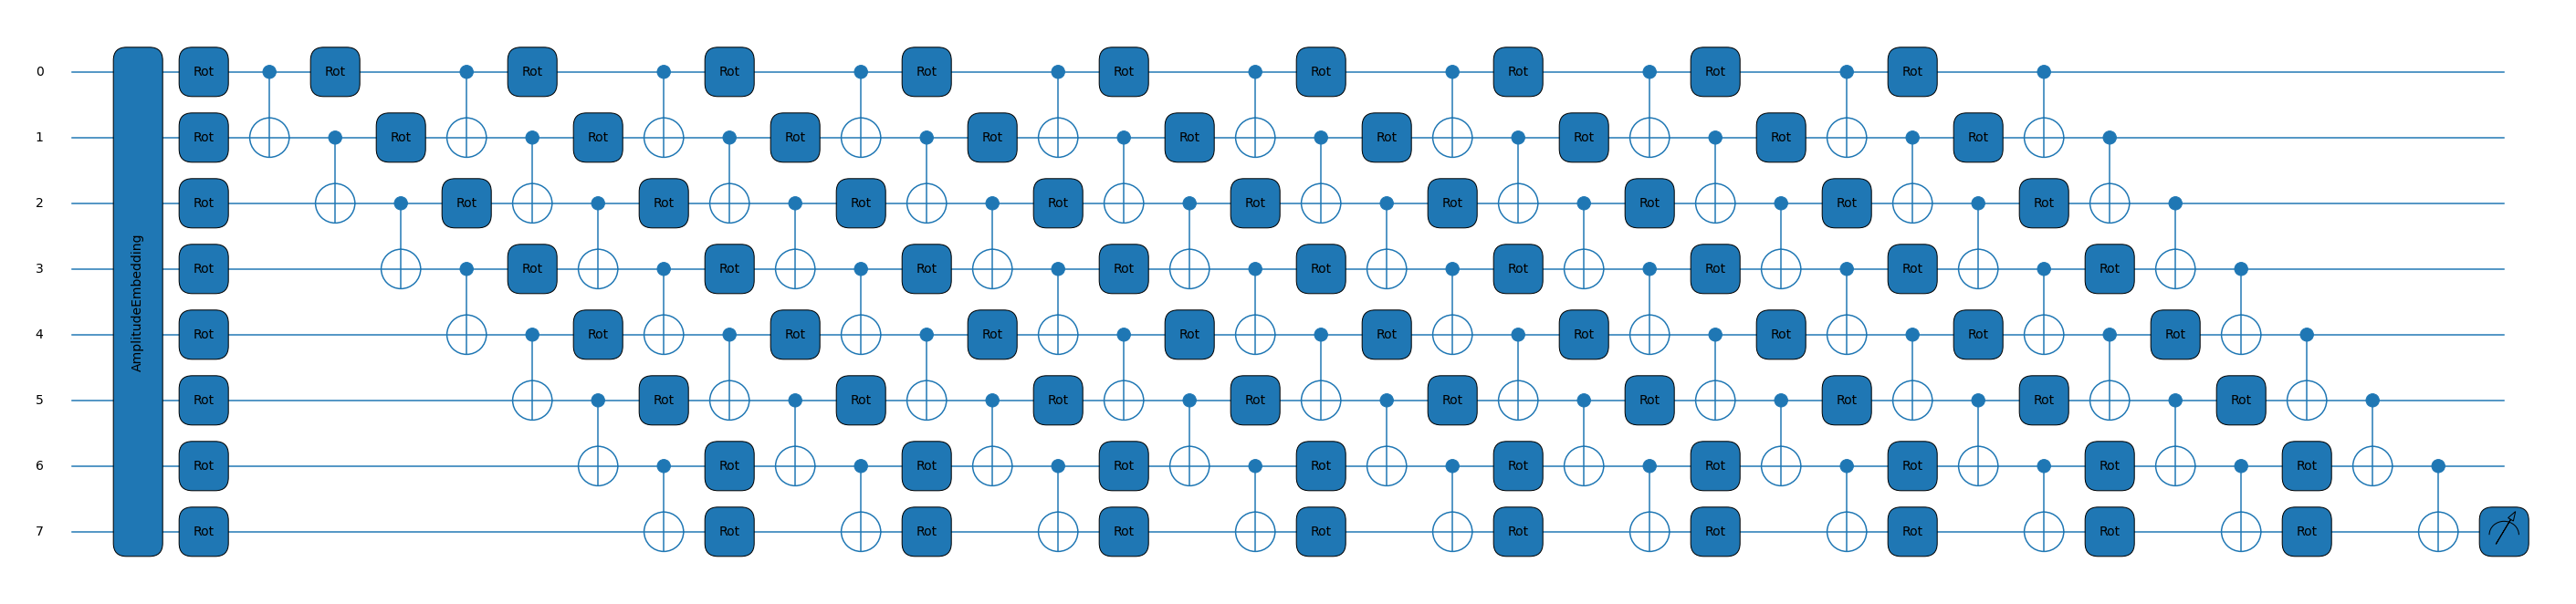

In [6]:
#查看量子线路
fig, ax = qml.draw_mpl(circuit)(weights_init,imgs_01_new)
fig.show()

In [8]:
#训练模型
valid_imgs_01=imgs_01_new[:50]    
valid_labels=labels_01[:50]
np.random.seed(0)
num_data = len(labels_01)  #数据个数
opt = NesterovMomentumOptimizer(0.05)
batch_size = 5    #一次5个

# train the variational classifier
weights = weights_init                   #真正训练的是这个
bias = bias_init
for it in range(1000):
    batch_index = np.random.randint(0, num_data, (batch_size,))   #在所有数据中选5个
    X_batch = imgs_01_new[batch_index]            #训练集选5个
    Y_batch = labels_01[batch_index]                    #对应的5个标签


    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)     #opt.step()，输入定义好的损失函数，权值，偏置，训练块，标签块，即可得到训练后的权值，偏置

    
    if(it%10==0):
        result=[variational_classifier(weights,bias,i) for i in valid_imgs_01]
        prediction=np.sign(result)
        acc=accuracy(valid_labels,prediction)
        print("第{}轮:cost:{},accuracy:{}%".format(it,cost(weights,bias,valid_imgs_01,valid_labels),acc*2))
        if(cost(weights,bias,valid_imgs_01,valid_labels)<0.45):
            break

第0轮:cost:0.9717173058636499,accuracy:60%


KeyboardInterrupt: 

识别错误的有： [1, 4, 8, 10, 14, 15]


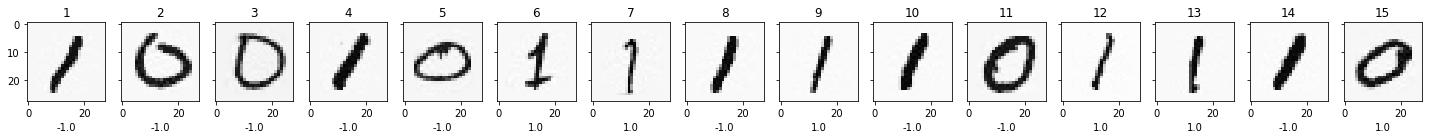

In [9]:
#测试该模型
error=[]
num=15
fig, ax = plt.subplots(nrows=1,ncols=num,sharex=True,sharey=True)
results=[]
n=np.random.randint(0,2128,size=num)
for i in range(num):
        result=np.sign(variational_classifier(weights,bias,imgs_01_new[n[i]]))
        ax[i].set_title(i+1)
        ax[i].set_xlabel(result)
        ax[i].imshow(imgs_recovered[n[i]].reshape(28,28), cmap='Greys', interpolation='nearest')
        if(result!=labels_01[n[i]]):
                error.append(i+1)
print("识别错误的有：",error)